## Notations
- B[1-9] : Bambous
- C[1-9] : Cracks
- D[1-9] : Dots
- G      : Green dragon
- R      : Red dragon
- 0      : White dragon
- N      : North wind
- E      : Est wind
- S      : South wind
- W      : West wind
- F      : Flower
- J      : Joker

## conventions d'écriture
- a()    : ensemble couleur 1
- b()    : ensemble couleur 2
- c()    : ensemble couleur 3
- d      : n'importe quel dragon
- <2468> : n'importe quel de ces chiffres, mais tous les groupes dans la mains doivent avoir le même nombre

In [17]:
#Mains
mains = [
    #2023 (0 à 3)
    "a(222) 0000 b(222) b(3333)",
    "FF a(2023) b(2222) c(3333)",
    "FFFF a(ddd) b(2023) c(ddd)",
    "a(22) 000 NEWS b(222) b(33)",

    #2468 (4 à 10)
    "FFFF a(2222) a(46) a(8888)",
    "a(22) a(46) a(88) b(<2468><2468><2468><2468>) c(<2468><2468><2468><2468>)",
    "a(222) a(4444) a(666) a(8888)",
    "a(222) a(4444) b(666) b(8888)",
    "a(22) a(4444) b(44) b(6666) c(88)",
    "a(222) a(888) b(dddd) c(dddd)",
    "FF a(222) a(44) a(66) a(888) a(dd)",

    #ANY LIKE NUMBERS (11 à 12)
    "FFFF a(<123456789><123456789><123456789><123456789>) b(<123456789><123456789>) c(<123456789><123456789><123456789><123456789>)",
    "FF a(<123456789><123456789><123456789>) a(d) b(<123456789><123456789><123456789>) b(d) c(<123456789><123456789><123456789>) c(d)",

    #ADDITION HANDS (13 à 16)
    "FF a(1111) b(1111) c(2222)",
    "FF a(2222) b(2222) c(4444)",
    "FF a(3333) b(3333) c(6666)",
    "FF a(4444) b(4444) c(8888)",

    #QUINTS (17 à 19)
    "a(<123456789><123456789><123456789><123456789><123456789>) (<NWSE><NWSE><NWSE><NWSE>) b(<123456789><123456789><123456789><123456789><123456789>)",
    "a(22) a(333) a(4444) a(55555)",
    "FFFF a(11111) b(22222)",

    #CONSECUTIVE RUN (20 à 30)
    "a(11) a(222) a(3333) a(444) a(55)",
    "a(55) a(666) a(7777) a(888) a(99)",
    "a(<123456><123456><123456>) a(<123456|1><123456|1><123456|1><123456|1>) a(<123456|2><123456|2><123456|2>) a(<123456|3><123456|3><123456|3><123456|3>)",
    "a(<123456><123456><123456>) a(<123456|1><123456|1><123456|1><123456|1>) b(<123456|2><123456|2><123456|2>) b(<123456|3><123456|3><123456|3><123456|3>)",
    "FF a(<12345678><12345678><12345678><12345678>) a(<12345678|1><12345678|1><12345678|1><12345678|1>) a(dddd)",
    "a(<12345>) a(<12345|1><12345|1>) a(<12345|2><12345|2><12345|2>) b(<12345|3><12345|3><12345|3><12345|3>) c(<12345|4><12345|4><12345|4><12345|4>)",
    "FF a(<1234567><1234567><1234567><1234567>) a(<1234567|1><1234567|1><1234567|1><1234567|1>) a(<1234567|2><1234567|2><1234567|2><1234567|2>)",
    "FF a(<1234567><1234567><1234567><1234567>) b(<1234567|1><1234567|1><1234567|1><1234567|1>) c(<1234567|2><1234567|2><1234567|2><1234567|2>)",
    "a(<12345678><12345678><12345678>) a(<12345678|1><12345678|1><12345678|1><12345678|1>) b(<12345678><12345678><12345678>) b(<12345678|1><12345678|1><12345678|1><12345678|1>)",
    "FFFF a(<1234567><1234567>) a(<1234567|1><1234567|1>) b(<1234567|2><1234567|2><1234567|2>) c(<1234567|2><1234567|2><1234567|2>)",
    "FF a(<123456><123456><123456>) a(<123456|1><123456|1>) a(<123456|2><123456|2>) a(<123456|3><123456|3><123456|3>) a(dd)",
    
    #13579 (31 à 44)
    "a(11) a(333) a(5555) a(777) a(99)",
    "a(11) a(333) b(5555) c(777) c(99)",
    "a(111) a(3333) b(333) b(5555)",
    "a(555) a(7777) b(777) b(9999)",
    "FF a(1111) b(3333) c(5555)",
    "FF a(5555) b(7777) c(9999)",
    "FF a(1111) a(33) a(5555) a(dd)",
    "FF a(5555) a(77) a(9999) a(dd)",
    "a(11) a(333) b(dddd) c(333) c(55)",
    "a(55) a(777) b(dddd) c(777) c(99)",
    "FFFF a(11) a(33) b(555) c(555)",
    "FFFF a(55) a(77) b(999) c(999)",
    "a(1111) b(33) b(55) b(77) a(9999)",
    "a(111) a(3) a(555) b(555) b(7) b(999)",

    #WINDS / DRAGONS (45 à 55)
    "NNNN EEE WWW SSSS",
    "NNN EEEE WWWW SSS",
    "NNN SSS a(<1234567><1234567>) a(<1234567|1><1234567|1>) a(<1234567|2><1234567|2><1234567|2><1234567|2>)",
    "EEE WWW a(<1234567><1234567>) a(<1234567|1><1234567|1>) a(<1234567|2><1234567|2><1234567|2><1234567|2>)",
    "NNNN SSSS a(ddd) b(ddd)",
    "EEEE WWWW a(ddd) b(ddd)",
    "FF NNNN a(2023) SSSS",
    "FF EEEE a(2023) WWWW",
    "FFFF N EE WWW SSSS",
    "a(dddd) NN EW SS b(dddd)",
    "NNN EW SSS a(<12345678><12345678><12345678>) b(<12345678|1><12345678|1><12345678|1>)",

    #368 (56 à 63)
    "a(333) a(6666) b(666) b(9999)",
    "FFFF a(3333) a(66) a(9999)",
    "FFFF a(3333) b(66) c(9999)",
    "a(33) a(66) b(333) b(666) c(9999)",
    "FF a(33) a(66) a(99) b(ddd) c(ddd)",
    "a(3) a(66) a(999) b(3333) c(3333)",
    "a(3333) b(666) a(9999) b(ddd)",
    "a(333) a(6) a(999) b(333) b(6) b(999)",

    #SINGLES and PAIRS (64 à 69)
    "a(11) a(357) a(99) b(11) b(357) b(99)",
    "FF a(<12345678><12345678>) a(<12345678|1><12345678|1>) b(<12345678><12345678>) b(<12345678|1><12345678|1>) c(<12345678><12345678>) c(<12345678|1><12345678|1>)",
    "a(33) a(66) a(99) a(d) b(33) b(66) b(99) b(d)",
    "FF a(2) a(4) a(66) a(88) b(2) b(4) b(66) b(88)",
    "a(<123><123>) a(<123|1><123|1>) a(<123|2><123|2>) a(<123|3><123|3>) a(<123|4><123|4>) a(<123|5><123|5>) a(<123|6><123|6>)",
    "FF a(2023) b(2023) c(2023)"


]

In [18]:

import re
from itertools import permutations
import pandas as pd

def analyseMain(main, id_main):
    main = main.translate(str.maketrans('', '', '()'))
    ensembles = main.split()

    structure = {
        'a' : [],   #Couleur 1
        'b' : [],   #Couleur 2
        'c' : [],   #Couleur 3
        'e' : [],    #Autres
        'g' : [],    #Groupes numériques (comme <2468>)
        'ge': []    #Groupes non numériques (comme <NEWS>)
    }

    nbCouleurs = 0
    couleurs = ['B', 'C', 'D']

    for ensemble in ensembles:
        if ensemble[0] == '<':
            #Cas d'un groupe non colorisé
            mains, g, ge = decoupeEnsemble(ensemble[0:], structure, 'extra')
            structure['e'].append(mains)
            structure['g'] = g
            structure['ge'] = ge
        elif ensemble[0] in ['a','b','c']:
            if len(structure[ensemble[0]]) == 0:
                nbCouleurs = nbCouleurs +1
            mains, g, ge = decoupeEnsemble(ensemble[1:], structure, 'couleur')
            structure[ensemble[0]].append(mains)
            structure['g'] = g
            structure['ge'] = ge
        else:
            mains, g, ge = decoupeEnsemble(ensemble, structure, 'naturel')
            structure['e'].append(mains)
            structure['g'] = g
            structure['ge'] = ge
    

    combinaisons = list(permutations(couleurs, nbCouleurs))
    mainsPossibles = []
    for combinaison in combinaisons:
        mainsPossibles = mainsPossibles + calculerMainsDerivees(structure, combinaison, nbCouleurs)

    mainsPossibles = pd.DataFrame(mainsPossibles, columns=['1','2','3','4','5','6','7','8','9','10','11','12','13','14'])

    #Suppression des mains en doubles
    # Créer une colonne temporaire avec les valeurs triées
    mainsPossibles['sorted_values'] = mainsPossibles.iloc[:, 1:15].apply(lambda row: tuple(sorted(row)), axis=1)

    # Supprimer les doublons basés sur cette colonne + id_main
    df_unique = mainsPossibles.drop_duplicates(subset=['sorted_values'], keep='first')

    # Supprimer la colonne temporaire
    mainsPossibles = df_unique.drop('sorted_values', axis=1)

    mainsPossibles['id_main'] = id_main



    return mainsPossibles


#3  types de typeGroupe :
#   - naturel (regroupement naturel, ex 1111)
#   - couleur (regroupement couleur, ex a(1111))
#   - extra   (regroupement d'extra variables ex <NEWS>*2)
def decoupeEnsemble(ensemble, structure, typeGroupe='naturel'):
    tiles = []
    groupes = structure['g']
    groupesNonColorises = structure['ge']

    #Cas <2468>
    if ensemble[0] == '<':
        segments = ensemble.split("<")
        for s in segments:
            if len(s) > 1:
                groupName = f"<{s}"
                if typeGroupe == "extra":
                    if groupName not in groupesNonColorises:
                        groupesNonColorises.append(groupName)
                else:
                    segmentsAdd = s.split("|")
                    if len(segmentsAdd) == 1:
                        if groupName not in groupes:
                            groupes.append(groupName)
        if typeGroupe == "extra":
            for g in groupesNonColorises:
                count = ensemble.count(g)
                if count > 0:
                    tiles.append(f"{g}*{count}")
        else:
            for g in groupes:
                baseName = g[1:-1]
                for i in range(1, 10):
                    groupName = f"<{baseName}|{i}>"
                    count = ensemble.count(groupName)
                    if count > 0:
                        tiles.append(f"{groupName}*{count}")
                groupName = f"<{baseName}>"
                count = ensemble.count(groupName)
                if count > 0:
                    tiles.append(f"{groupName}*{count}")

    else:
        for c in ensemble:
            tiles.append(c)

    return tiles, groupes, groupesNonColorises

def calculerMainsDerivees(structure, combinaison, nbCouleurs):
    mainsDerivees = []

    #Multiplicateur 1 : ge
    #Multiplicateur 2 : g
    #Multiplicateur 3 : combinaison de couleur

    if len(structure['ge']) > 0:
        #On a des groupes extra spécifiques
        for ge in structure['ge']:
            values = ge.translate(str.maketrans('', '', '<>'))
            for v in values:
                mainsDerivees = mainsDerivees + calculerMainsDeriveesM1(structure, combinaison, nbCouleurs, ge, v)
    else:
        mainsDerivees = mainsDerivees + calculerMainsDeriveesM1(structure, combinaison, nbCouleurs)


    return mainsDerivees

#Multiplicateur Groupe extra
def calculerMainsDeriveesM1(structure, combinaison, nbCouleurs, geCode = None, geValue = None):
    mainsDerivees = []

    if len(structure['g']) > 0:
        #On a des groupes couleur spécifiques
        for g in structure['g']:
            values = g.translate(str.maketrans('', '', '<>'))
            for v in values:
                mainsDerivees = mainsDerivees + calculerMainsDeriveesM2(structure, combinaison, nbCouleurs, geCode, geValue, g, v)
    else:
        mainsDerivees = mainsDerivees + calculerMainsDeriveesM2(structure, combinaison, nbCouleurs, geCode, geValue)
    
    return mainsDerivees


#Multiplicateur groupe couleur
def calculerMainsDeriveesM2(structure, combinaison, nbCouleurs, geCode = None, geValue = None, gCode = None, gValue = None):
    main = []

    groupesCouleur = ['a', 'b', 'c']
    combinaisonDragons = {
        'B' : 'G',
        'C' : 'R',
        'D' : '0'
    }

    for gc in range(0, nbCouleurs):
        couleur = groupesCouleur[gc]
        for groupe in structure[couleur]:
            for tile in groupe:
                if tile == "J":
                    #Cas du joker
                    main.append("J")
                elif tile[0] == '<':
                    #Cas d'un groupe spécifique
                    count = int(tile.split("*")[1])
                    nomGroupe = tile.split("*")[0]
                    if nomGroupe == gCode:
                        for i in range(0, count):
                            main.append(f"{combinaison[gc]}{gValue}")
                    #Traitement des incréments de valeur
                    nomGroupe = nomGroupe.translate(str.maketrans('', '', '<>'))
                    splitIncrement = nomGroupe.split("|")
                    if len(splitIncrement) == 2:
                        nomGroupe = f"<{splitIncrement[0]}>"
                        if nomGroupe == gCode:
                            increment = splitIncrement[1]
                            for i in range(0, count):
                                main.append(f"{combinaison[gc]}{int(gValue)+int(increment)}")

                elif tile == 'd':
                    #Cas de dragons (non déterminés)
                    main.append(f"{combinaisonDragons[combinaison[gc]]}")
                elif tile == '0':
                    #Cas du dragon blanc
                    main.append(f"{tile}")
                else:
                    #Autre cas
                    main.append(f"{combinaison[gc]}{tile}")
    for groupe in structure['e']:
        for tile in groupe:
            if tile[0] == '<':
                count = int(tile.split("*")[1])
                nomGroupe = tile.split("*")[0]
                if nomGroupe == geCode:
                    for i in range(0, count):
                        main.append(f"{geValue}")
            else:
                main.append(tile)
    return [main]






In [19]:
#Générer toutes les mains

allDf = []
i = 1
for main in mains:
    allDf.append(analyseMain(main, i))
    i = i+1


possibilites = pd.concat(allDf, ignore_index=True)

In [20]:
possibilites

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id_main
0,B2,B2,B2,C2,C2,C2,C3,C3,C3,C3,0,0,0,0,1
1,B2,B2,B2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1
2,C2,C2,C2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1
3,C2,C2,C2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1
4,D2,D2,D2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,D2,D2,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,69
929,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,D9,D9,69
930,B2,0,B2,B3,C2,0,C2,C3,D2,0,D2,D3,F,F,70
931,C2,0,C2,C3,B2,0,B2,B3,D2,0,D2,D3,F,F,70


## Calculer la probabilité de faire des mains

### Méthode 1

In [21]:
#mahjong
deck = {
    'B1' : 4,
    'B2' : 4,
    'B3' : 4,
    'B4' : 4,
    'B5' : 4,
    'B6' : 4,
    'B7' : 4,
    'B8' : 4,
    'B9' : 4,
    'C1' : 4,
    'C2' : 4,
    'C3' : 4,
    'C4' : 4,
    'C5' : 4,
    'C6' : 4,
    'C7' : 4,
    'C8' : 4,
    'C9' : 4,
    'D1' : 4,
    'D2' : 4,
    'D3' : 4,
    'D4' : 4,
    'D5' : 4,
    'D6' : 4,
    'D7' : 4,
    'D8' : 4,
    'D9' : 4,
    'N' : 4,
    'E' : 4,
    'S' : 4,
    'W' : 4,
    'G' : 4,
    'R' : 4,
    '0' : 4,
    'F' : 8
}

In [22]:
import math
from itertools import combinations

def calculer_probabilite_combinaison(
    deck_composition,      # Dict: {'A': 10, 'B': 5, ...}
    main_actuelle,         # Dict: {'A': 1, 'B': 3, ...}
    defausse,             # Dict: {'A': 2, 'C': 3, ...}
    combinaison_cible,    # Dict: {'A': 1, 'B': 1, 'C': 1, 'D': 1}
    nbCartes
):
    """
    Calcule la probabilité d'obtenir une combinaison cible
    """
    # Calculer les cartes disponibles dans le deck
    deck_restant = {}
    for carte, total in deck_composition.items():
        en_main = main_actuelle.get(carte, 0)
        en_defausse = defausse.get(carte, 0)
        deck_restant[carte] = total - en_main - en_defausse
    
    # Nombre total de cartes restantes
    R = sum(deck_restant.values())
    
    # Identifier les cartes manquantes
    cartes_manquantes = {}
    for carte, besoin in combinaison_cible.items():
        possede = main_actuelle.get(carte, 0)
        manque = besoin - possede
        if manque > 0:
            disponible = deck_restant.get(carte, 0)
            if disponible < manque:
                # Impossible d'obtenir la combinaison
                return 0.0
            cartes_manquantes[carte] = (manque, disponible)
    
    # Si rien ne manque, probabilité = 1
    if not cartes_manquantes:
        return 1.0
    
    # Vérifier qu'on pioche assez de cartes
    total_manquant = sum(m for m, _ in cartes_manquantes.values())

    n=nbCartes
    if n < total_manquant:
        return 0.0
    
    # Appliquer l'inclusion-exclusion
    types_manquants = list(cartes_manquantes.keys())
    prob_echec = 0.0
    
    # Pour chaque sous-ensemble non vide des types manquants
    for r in range(1, len(types_manquants) + 1):
        for subset in combinations(types_manquants, r):
            # Calculer combien de cartes ne sont PAS dans ce subset
            cartes_hors_subset = R
            for carte in subset:
                cartes_hors_subset -= cartes_manquantes[carte][1]
            
            # Si on ne peut pas piocher n cartes sans ce subset
            if cartes_hors_subset < n:
                continue
            
            # P(aucune carte de ce subset)
            prob = math.comb(cartes_hors_subset, n) / math.comb(R, n)
            
            # Inclusion-exclusion: alterne +/-
            if r % 2 == 1:
                prob_echec += prob
            else:
                prob_echec -= prob
    
    return 1.0 - prob_echec


# Exemple avec votre cas initial
main = {'B1' : 1, 'B2' : 2, 'B3' : 3, 'C4' : 4, 'D5' : 3}
defausse = {}
cible = {'B1' : 1, 'B2' : 2, 'B3' : 3, 'C4' : 4, 'D5' : 4}

prob = calculer_probabilite_combinaison(deck, main, defausse, cible, 14)
print(f"Probabilité : {prob:.2%}")  # ~8.33%

Probabilité : 10.69%


In [23]:
mainsPossibles = possibilites.copy()
colonnes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
mainsPossibles["dict"] = mainsPossibles[colonnes].apply(lambda row: row.value_counts().to_dict(), axis=1)

In [24]:
mainsPossibles

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id_main,dict
0,B2,B2,B2,C2,C2,C2,C3,C3,C3,C3,0,0,0,0,1,"{'0': 4, 'C3': 4, 'C2': 3, 'B2': 3}"
1,B2,B2,B2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1,"{'0': 4, 'D3': 4, 'D2': 3, 'B2': 3}"
2,C2,C2,C2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1,"{'0': 4, 'B3': 4, 'B2': 3, 'C2': 3}"
3,C2,C2,C2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1,"{'0': 4, 'D3': 4, 'D2': 3, 'C2': 3}"
4,D2,D2,D2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1,"{'0': 4, 'B3': 4, 'B2': 3, 'D2': 3}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,D2,D2,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,69,"{'D2': 2, 'D3': 2, 'D4': 2, 'D5': 2, 'D6': 2, 'D7': 2, 'D8': 2}"
929,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,D9,D9,69,"{'D3': 2, 'D4': 2, 'D5': 2, 'D6': 2, 'D7': 2, 'D8': 2, 'D9': 2}"
930,B2,0,B2,B3,C2,0,C2,C3,D2,0,D2,D3,F,F,70,"{'0': 3, 'B2': 2, 'C2': 2, 'D2': 2, 'F': 2, 'B3': 1, 'C3': 1, 'D3': 1}"
931,C2,0,C2,C3,B2,0,B2,B3,D2,0,D2,D3,F,F,70,"{'0': 3, 'C2': 2, 'B2': 2, 'D2': 2, 'F': 2, 'C3': 1, 'B3': 1, 'D3': 1}"


In [25]:
def calculProbabilitesMains(deck, mainsPossibles, defausse, main):
    mainsPossibles["probabilite"] = mainsPossibles.apply(lambda row: calculer_probabilite_combinaison(deck, main, defausse, row["dict"], 5), axis=1)
    print(mainsPossibles.sort_values(['probabilite'], ascending=[False]))



In [26]:
from collections import Counter

#Mettons la main suivante
main = ["B2", "B2", "B2", "C2", "C2", "C2", "C3", "C3", "C3", "C3", "0", "0", "0", "G"]

#quelle est la probabilité de faire mah jong dans les 14 prochains coups ?
probabilites = calculProbabilitesMains(deck, mainsPossibles, {}, dict(Counter(main)))


      1   2   3   4   5   6   7   8   9  10  11  12  13  14  id_main  \
568  B2  B2  B2  B3  B3  B3  B3  C2  C2  C2  C3  C3  C3  C3       29   
584  C2  C2  C2  C3  C3  C3  C3  B2  B2  B2  B3  B3  B3  B3       29   
0    B2  B2  B2  C2  C2  C2  C3  C3  C3  C3   0   0   0   0        1   
2    C2  C2  C2  B2  B2  B2  B3  B3  B3  B3   0   0   0   0        1   
5    D2  D2  D2  C2  C2  C2  C3  C3  C3  C3   0   0   0   0        1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..      ...   
318  D1  D1  D1  D1  D1  B1  B1  B1  B1  B1   W   W   W   W       18   
319  D2  D2  D2  D2  D2  B2  B2  B2  B2  B2   W   W   W   W       18   
320  D3  D3  D3  D3  D3  B3  B3  B3  B3  B3   W   W   W   W       18   
321  D4  D4  D4  D4  D4  B4  B4  B4  B4  B4   W   W   W   W       18   
307  C8  C8  C8  C8  C8  D8  D8  D8  D8  D8   E   E   E   E       18   

                                     dict  probabilite  
568  {'B3': 4, 'C3': 4, 'B2': 3, 'C2': 3}     0.146802  
584  {'C3': 4, 'B3': 

### Méthode 2

In [27]:
mainsPossibles

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id_main,dict,probabilite
0,B2,B2,B2,C2,C2,C2,C3,C3,C3,C3,0,0,0,0,1,"{'0': 4, 'C3': 4, 'C2': 3, 'B2': 3}",0.038462
1,B2,B2,B2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1,"{'0': 4, 'D3': 4, 'D2': 3, 'B2': 3}",0.000000
2,C2,C2,C2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1,"{'0': 4, 'B3': 4, 'B2': 3, 'C2': 3}",0.004604
3,C2,C2,C2,D2,D2,D2,D3,D3,D3,D3,0,0,0,0,1,"{'0': 4, 'D3': 4, 'D2': 3, 'C2': 3}",0.000000
4,D2,D2,D2,B2,B2,B2,B3,B3,B3,B3,0,0,0,0,1,"{'0': 4, 'B3': 4, 'B2': 3, 'D2': 3}",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,D2,D2,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,69,"{'D2': 2, 'D3': 2, 'D4': 2, 'D5': 2, 'D6': 2, 'D7': 2, 'D8': 2}",0.000000
929,D3,D3,D4,D4,D5,D5,D6,D6,D7,D7,D8,D8,D9,D9,69,"{'D3': 2, 'D4': 2, 'D5': 2, 'D6': 2, 'D7': 2, 'D8': 2, 'D9': 2}",0.000000
930,B2,0,B2,B3,C2,0,C2,C3,D2,0,D2,D3,F,F,70,"{'0': 3, 'B2': 2, 'C2': 2, 'D2': 2, 'F': 2, 'B3': 1, 'C3': 1, 'D3': 1}",0.000000
931,C2,0,C2,C3,B2,0,B2,B3,D2,0,D2,D3,F,F,70,"{'0': 3, 'C2': 2, 'B2': 2, 'D2': 2, 'F': 2, 'C3': 1, 'B3': 1, 'D3': 1}",0.000000


In [28]:
#Méthode 2

def calculProbabilitesMains2(deck, mainsPossibles, defausse, main):
    mainCounter = dict(Counter(main))

    mainsPossibles["probabilite"] = mainsPossibles.apply(lambda row: calculerProbabiliteCombinaison(deck, main, mainCounter, defausse, row), axis=1)
    return mainsPossibles.sort_values(['probabilite'], ascending=[False])


def calculerProbabiliteCombinaison(deck, main, mainCounter, defausse, combinaison):
    sumProbabilite = 0

    for tuile in combinaison["dict"]:
        #Nombre voulu de cette tuile
        nbAttendu = combinaison["dict"][tuile]

        #Nombre possédé
        nbMain = 0
        if tuile in mainCounter:
            nbMain = mainCounter[tuile]

        #Ajout de probabilités à 1 pour celles voulues et déjà possédées
        nbDejaPossedes = nbMain
        if nbMain > nbAttendu:
            nbDejaPossedes = nbAttendu
        sumProbabilite = sumProbabilite + (nbDejaPossedes * 1)

        #Celles restant à posseder
        if nbAttendu > nbMain:
            nbRestant = nbAttendu-nbMain
            probabilite = getProbabiliteTuile(deck, defausse, main, mainCounter, tuile, nbRestant)
            if probabilite == -1:
                return -1
            sumProbabilite = sumProbabilite + (probabilite * nbRestant)

    probabiliteFinale = float(sumProbabilite/14)

    return probabiliteFinale

        

def getProbabiliteTuile(deck, defausse, main, mainCounter, tuile, nbSouhaite):
    #On calcule le nombre total de tuiles restantes

    #nombre total dans le jeu
    nbTotalEnJeu = deck[tuile]

    #Nombre défaussées
    nbDefausse = 0
    if tuile in defausse:
        nbDefausse = defausse[tuile]

    #Nombre déjà en main
    #On considère que ces tuiles de la main sont déjà utilisées (non dispo)
    nbMain = 0
    if tuile in main:
        nbMain = mainCounter[tuile]


    #Nombre total de tuiles dans le jeu
    nbTotal = sum(deck.values())

    #Nombres de tuiles possédées par le joueur
    nbTotalJoueur = sum(mainCounter.values())

    #Nombre de tuiles restant dans la pioche
    nbRestantPioche = nbTotal - (nbTotalJoueur + sum(defausse.values()))

    #Nombe de tuiles de ce type restant
    nbRestant = (nbTotalEnJeu - (nbDefausse + nbMain))

    #Cas spécifique : plus de tuile dispo
    if nbRestant < nbSouhaite:
        return -1
    
    #Calcul de la probabilité
    probabilite = nbRestant/nbRestantPioche

    return probabilite


    #TODO : intégrer les éventuelles tuiles déjà posées par les autres joueurs

#CIBLE
#B2	B2	B2	C2	C2	C2	C3	C3	C3	C3	0	0	0	0
#Mettons la main suivante
main = ["B2", "B2", "B2", "C2", "C2", "C2", "C3", "C3", "C3", "C3", "0", "0", "0", "G"]
defausse = {
    '0' : 0
}

proba = calculProbabilitesMains2(deck, mainsPossibles, defausse, main)
proba

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id_main,dict,probabilite
0,B2,B2,B2,C2,C2,C2,C3,C3,C3,C3,0,0,0,0,1,"{'0': 4, 'C3': 4, 'C2': 3, 'B2': 3}",0.929121
18,B2,B2,C2,C2,C2,C3,C3,0,0,0,N,E,W,S,4,"{'C2': 3, '0': 3, 'B2': 2, 'C3': 2, 'N': 1, 'E': 1, 'W': 1, 'S': 1}",0.723077
584,C2,C2,C2,C3,C3,C3,C3,B2,B2,B2,B3,B3,B3,B3,29,"{'C3': 4, 'B3': 4, 'C2': 3, 'B2': 3}",0.723077
568,B2,B2,B2,B3,B3,B3,B3,C2,C2,C2,C3,C3,C3,C3,29,"{'B3': 4, 'C3': 4, 'B2': 3, 'C2': 3}",0.723077
5,D2,D2,D2,C2,C2,C2,C3,C3,C3,C3,0,0,0,0,1,"{'0': 4, 'C3': 4, 'C2': 3, 'D2': 3}",0.721429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,B9,B9,B9,B9,B9,C9,C9,C9,C9,C9,N,N,N,N,18,"{'B9': 5, 'C9': 5, 'N': 4}",-1.000000
174,B1,B1,B1,B1,B1,C1,C1,C1,C1,C1,W,W,W,W,18,"{'B1': 5, 'C1': 5, 'W': 4}",-1.000000
175,B2,B2,B2,B2,B2,C2,C2,C2,C2,C2,W,W,W,W,18,"{'B2': 5, 'C2': 5, 'W': 4}",-1.000000
176,B3,B3,B3,B3,B3,C3,C3,C3,C3,C3,W,W,W,W,18,"{'B3': 5, 'C3': 5, 'W': 4}",-1.000000


## Estimation des performances

In [29]:
import random

#Mélange du deck
deckMelange = []
for cle, nombre in deck.items():
    deckMelange.extend([cle] * nombre)

# Réorganiser aléatoirement
random.shuffle(deckMelange)
deckMelange

['E',
 'C9',
 'D2',
 'D7',
 '0',
 'B4',
 'B7',
 'D3',
 'B3',
 'D7',
 'S',
 'D7',
 'D3',
 'W',
 'C8',
 'B3',
 'D6',
 'G',
 'D8',
 'S',
 'B2',
 'R',
 'D6',
 'D3',
 'B7',
 'B3',
 'C2',
 'C1',
 'B4',
 'B5',
 'B9',
 'B4',
 'C7',
 'D5',
 'D5',
 'C7',
 'B3',
 'B1',
 '0',
 'C1',
 'B7',
 'C6',
 'D1',
 'C4',
 'C9',
 'D5',
 'B8',
 'C5',
 'D8',
 'D9',
 'B2',
 'F',
 'C5',
 'W',
 'B4',
 'B8',
 'D5',
 'C1',
 'G',
 '0',
 'B1',
 'F',
 'C6',
 'N',
 'C3',
 'R',
 'D2',
 'C4',
 'D1',
 'B6',
 'C2',
 'B1',
 'C2',
 'F',
 'C7',
 'C1',
 'C3',
 'D2',
 'B6',
 'N',
 'D4',
 'B5',
 'C8',
 'G',
 'C6',
 'B9',
 'C2',
 'D9',
 'D3',
 'N',
 'C3',
 'W',
 'E',
 'D9',
 'S',
 'B8',
 'D8',
 'C7',
 'B8',
 'C9',
 'D1',
 'G',
 'B9',
 'B9',
 'W',
 'C4',
 '0',
 'S',
 'C5',
 'F',
 'D8',
 'R',
 'F',
 'C8',
 'D4',
 'E',
 'B7',
 'B2',
 'C8',
 'F',
 'B6',
 'D6',
 'D6',
 'D7',
 'D4',
 'C6',
 'R',
 'E',
 'C9',
 'N',
 'C4',
 'D4',
 'D1',
 'B5',
 'B2',
 'B1',
 'F',
 'D9',
 'C5',
 'D2',
 'C3',
 'B5',
 'B6',
 'F']

In [30]:
#Méthode permettant de déterminer, sur une main de 15 tuiles, laquelle est la plus intéressante à défausser

main = ["B2", "B2", "B2", "C2", "C2", "C2", "C3", "C3", "C3", "C3", "0", "0", "0", "G", "C4"]
defausse = {
    '0' : 0
}

def melangerDeck(deck):
    #Mélange du deck
    deckMelange = []
    for cle, nombre in deck.items():
        deckMelange.extend([cle] * nombre)

    # Réorganiser aléatoirement
    #random.seed(42)
    random.shuffle(deckMelange)
    return deckMelange


def choisirTuileADefausser(deck, deckMelange, mainsPossibles, defausse, main):
    perfs = []
    mains = []
    tuilesTestees = []

    mahjong = False

    for index in range(0, len(main)):
        mainReduite = main.copy()
        tuile = mainReduite.pop(index)
        tuilesTestees.append(tuile)

        proba = calculProbabilitesMains2(deck, mainsPossibles, defausse, mainReduite)
        #print(f"Si on défausse {tuile} on aura une probabilité de {proba.iloc[0]["probabilite"]}")

        perfs.append(proba.iloc[0]["probabilite"])
        mains.append(proba.iloc[0]["dict"])

    df = pd.DataFrame({'perfs' : perfs, 'mains' : mains, 'tuileTestee' : tuilesTestees}, columns=["perfs","mains","tuileTestee"])


    perfAsc = sorted(perfs)

    index_min = perfs.index(min(perfs))
    index_max = perfs.index(max(perfs))
    tuileADefausser = main[index_max]

    print(f"Probabilité cible : {max(perfs)}")
    mainCible = mains[perfs.index(max(perfs))]
    

    if(max(perfs) == 1):
        mahjong = True

    return tuileADefausser, mahjong, max(perfs), mainCible

def nouveauJeu(deck, mainsPossibles):
    #Nouveau deck
    deckMelange = melangerDeck(deck)

    #Suivi des performances
    suiviProbabilites = []
    suiviMains = []

    #Reinitialiser la defausse
    defausse = {}

    #Initialisation de la main
    main = []
    for i in range(0, 14):
        deckMelange, tuilePiochee = piocher(deckMelange)
        main.append(tuilePiochee)

    print("-------------------------------------")
    print(f"Main initiale : {main}")

    end = False
    i_tour = 0
    while end is False:
        i_tour = i_tour+1
        print(f"Tour de jeu {i_tour}")

        #On pioche
        deckMelange, tuilePiochee = piocher(deckMelange)

        #On ajoute la tuile à la main
        main.append(tuilePiochee)

        #On détermine ce qu'on jete
        tuileADefausser, mahjong, probabiliteCible, mainCible = choisirTuileADefausser(deck, deckMelange, mainsPossibles, defausse, main)
        suiviProbabilites.append(probabiliteCible)
        suiviMains.append(mainCible)

        if mahjong:
            print("Mah Jong !!!!")
            end = True

        #On modifie la main
        del main[main.index(tuileADefausser)]

        print(f"Main finale {main}")

        #On ajoute à la defausse
        if tuileADefausser in defausse:
            defausse[tuileADefausser] = defausse[tuileADefausser]+1
        else:
            defausse[tuileADefausser] = 1

        proba2 = calculProbabilitesMains2(deck, mainsPossibles, defausse, main)
        
        #On vérifie qu'il reste des tuiles dans la pioche
        if len(deckMelange) == 0:
            print("Fin de la pioche !!!!")
            end = True

    #Stats finales
    stats = pd.DataFrame({"probabilites" : suiviProbabilites, "mainCible" : suiviMains}, columns=["probabilites","mainCible"])
    return stats


def piocher(deckMelange):
    #Tuile piochée
    tuilePiochee = deckMelange.pop(0)

    return deckMelange, tuilePiochee

def tourDeJeu(deck, deckMelange, mainsPossibles, defausse, main):
    print("Tour de jeu")

stats = nouveauJeu(deck, mainsPossibles)
pd.set_option('display.max_colwidth', None)

stats



-------------------------------------
Main initiale : ['C6', 'C4', 'D8', 'B3', 'D2', 'B3', 'D5', 'F', 'D8', 'E', 'D2', 'B1', 'C6', 'B1']
Tour de jeu 1
Probabilité cible : 0.5170329670329671
Main finale ['C6', 'C4', 'D8', 'D2', 'B3', 'D5', 'F', 'D8', 'E', 'D2', 'B1', 'C6', 'B1', 'B7']
Tour de jeu 2
Probabilité cible : 0.5171650055370985
Main finale ['C6', 'C4', 'D8', 'B3', 'D5', 'F', 'D8', 'E', 'D2', 'B1', 'C6', 'B1', 'B7', 'C1']
Tour de jeu 3
Probabilité cible : 0.5172991071428571
Main finale ['C6', 'C4', 'D8', 'D5', 'F', 'D8', 'E', 'D2', 'B1', 'C6', 'B1', 'B7', 'C1', 'B8']
Tour de jeu 4
Probabilité cible : 0.5174353205849268
Main finale ['C6', 'C4', 'D8', 'F', 'D8', 'E', 'D2', 'B1', 'C6', 'B1', 'B7', 'C1', 'B8', 'R']
Tour de jeu 5
Probabilité cible : 0.5175736961451247
Main finale ['C6', 'C4', 'D8', 'F', 'D8', 'D2', 'B1', 'C6', 'B1', 'B7', 'C1', 'B8', 'R', 'D7']
Tour de jeu 6
Probabilité cible : 0.5177142857142857
Main finale ['C6', 'C4', 'D8', 'F', 'D8', 'D2', 'C6', 'B1', 'B7', 'C1',

,probabilites,mainCible
0,0.517033,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
1,0.517165,"{'C6': 2, 'F': 2, 'C8': 2, 'D8': 2, 'D6': 2, 'C2': 1, 'C4': 1, 'D2': 1, 'D4': 1}"
2,0.517299,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
3,0.517435,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
4,0.517574,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
5,0.517714,"{'C6': 2, 'F': 2, 'C8': 2, 'D8': 2, 'D6': 2, 'C2': 1, 'C4': 1, 'D2': 1, 'D4': 1}"
6,0.520161,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
7,0.520325,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
8,0.520492,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
9,0.586777,"{'B7': 2, 'B8': 2, 'C7': 2, 'C8': 2, 'D7': 2, 'D8': 2, 'F': 2}"


In [31]:
stats

,probabilites,mainCible
0,0.517033,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
1,0.517165,"{'C6': 2, 'F': 2, 'C8': 2, 'D8': 2, 'D6': 2, 'C2': 1, 'C4': 1, 'D2': 1, 'D4': 1}"
2,0.517299,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
3,0.517435,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
4,0.517574,"{'D6': 2, 'F': 2, 'D8': 2, 'C8': 2, 'C6': 2, 'D2': 1, 'D4': 1, 'C2': 1, 'C4': 1}"
5,0.517714,"{'C6': 2, 'F': 2, 'C8': 2, 'D8': 2, 'D6': 2, 'C2': 1, 'C4': 1, 'D2': 1, 'D4': 1}"
6,0.520161,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
7,0.520325,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
8,0.520492,"{'F': 4, 'D8': 3, 'B8': 3, 'C6': 2, 'C7': 2}"
9,0.586777,"{'B7': 2, 'B8': 2, 'C7': 2, 'C8': 2, 'D7': 2, 'D8': 2, 'F': 2}"


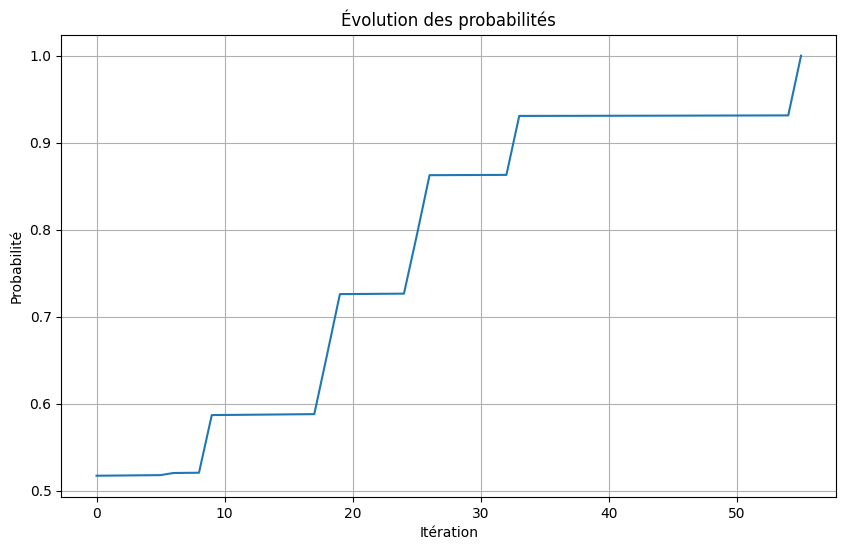

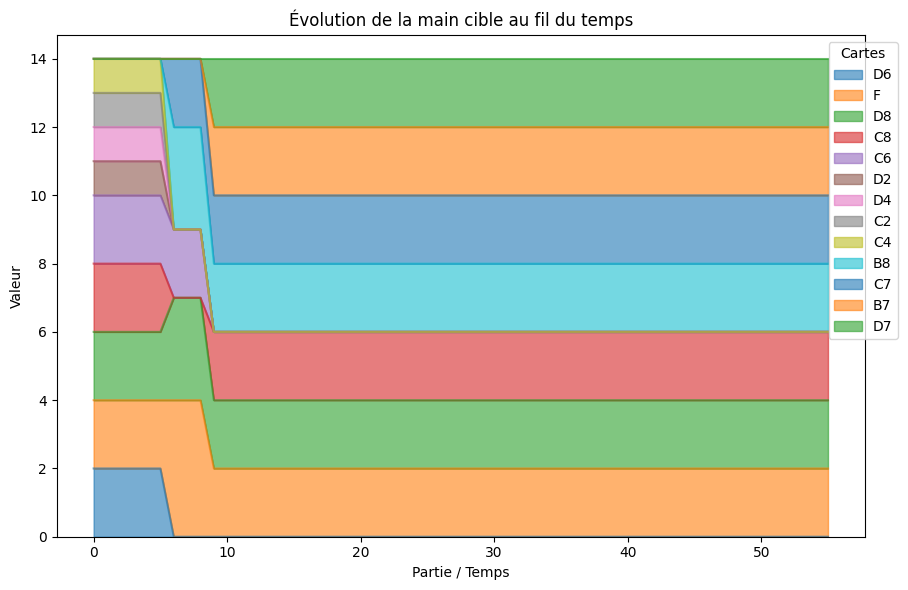

In [32]:
import matplotlib.pyplot as plt

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(stats['probabilites'])
plt.xlabel('Itération')
plt.ylabel('Probabilité')
plt.title('Évolution des probabilités')
plt.grid(True)
plt.show()

# Convertir les dictionnaires en colonnes
main_expanded = pd.json_normalize(stats['mainCible'])

# Graphique en aires empilées
main_expanded.plot(kind='area', stacked=True, alpha=0.6, figsize=(10, 6))
plt.title("Évolution de la main cible au fil du temps")
plt.xlabel("Partie / Temps")
plt.ylabel("Valeur")
plt.legend(title="Cartes", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()